In [7]:
# !pip install pandas
# !pip install matplotlib
# !pip install scipy
# !pip install codac
# !pip install trustregion
# !pip install networkx


In [8]:
from codac import Interval, IntervalVector, CtcDist, Function,CtcFunction
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import networkx as nx
from scipy.optimize import minimize, minimize_scalar
from scipy.spatial.transform import Rotation as Rot
import copy

N_ATOMS = 63

/home/perce/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:493: UserWarning: Signature b'\xcc\xcc\xcc\xbd' for <class 'numpy.float32'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/perce/.local/lib/python3.10/site-packages/numpy/core/_machar.py:295: RuntimeWarning: overflow encountered in divide
  xmax = xmax / (xmin*beta*beta*beta)


In [9]:
f= open("graph_02.txt", mode="r")
li = []
for line in f:
    li.append(line)

In [10]:
f.close()

In [11]:
# def get_f_ctc(sub1, sub2, dico_interval, point, axis):
#     li_ctc = []
#     li_constrains = []
#     li_f = []

#     #pour verifier
#     axis /= np.linalg.norm(axis)

#     for atom1 in sub1.sub.nodes:
#         for atom2 in sub2.sub.nodes:
#             if atom1 == atom2:
#                 continue
#             try:
#                 mini, maxi = dico_interval[(i,j)][0], dico_interval[(i,j)][1]
#             except KeyError:
#                 continue
            
#             #define_domaine
#             low = 0
#             up = np.pi * 2
#             li_constrains.append([low,up])

#             vector1 = sub1.X[sub1.index_to_X[atom1]]
#             vector2 = sub2.X[sub2.index_to_X[atom2]]

#             vector2_unchanged = point + (np.dot(vector2, axis)*axis)
#             vector2_changed = vector2 - vector2_unchanged
#             #la ta fonction elle calcule la taille entre l'atome 1 et l atome 2 si la rotation d'angle theta est effectué,
#             #jsp comment tu peux/veux ajouter la contrainte sur mini et maxi mais en tout cas tout est la 
#             f = Function("theta", f"sqrt(sqr(
#                             {vector2_unchanged[0]} + 
#                             cos(theta){axis[2]}*cos(theta * {axis[1]})*{vector2_changed[0]} + 
#                             (cos(theta * {axis[2]})*sin(theta * {axis[1]})*sin(theta * {axis[0]}) - sin(theta * {axis[2]})*cos(theta * {axis[0]}))*{vector2_changed[1]} +
#                             (cos(theta * {axis[2]})*sin(theta * {axis[1]})*sin(theta * {axis[0]}) + sin(theta * {axis[2]})*sin(theta * {axis[0]}))*{vector2_changed[2]} +
#                             -{vector1[0]})+sqr(
#                             {vector2_unchanged[1]} + 
#                             sin(theta * {axis[2]})*cos(theta * {axis[1]})*{vector2_changed[0]} + 
#                             (sin(theta * {axis[2]})*sin(theta * {axis[1]})*sin(theta * {axis[0]}) + cos(theta * {axis[2]})*cos(theta * {axis[0]}))*{vector2_changed[1]} +
#                             (sin(theta * {axis[2]})*sin(theta * {axis[1]})*sin(theta * {axis[0]}) - cos(theta * {axis[2]})*sin(theta * {axis[0]}))*{vector2_changed[2]} +
#                             -{vector1[1]})+sqr(
#                             {vector2_unchanged[2]} + 
#                             -sin(theta * {axis[1]})*{vector2_changed[0]} + 
#                             cos(theta * {axis[1]})*sin(theta * {axis[0]})*{vector2_changed[1]} +
#                             cos(theta * {axis[1]})*cos(theta * {axis[0]})*{vector2_changed[2]} +                            
#                             -{vector1[2]}))")
#             li_f.append(f)
#         contractor = CtcFunction(f, Interval(low,up))
#         li_ctc.append(contractor)

# return li_ctc,li_f, li_constrains


## Marco Part, let's rock it baby

In [12]:
dico_constrains = {}
dico_interval = {}
dico_init_inter = {}
list_relation = []
for elem in li:
    i = int(elem[6:8].split(" ")[-1])-1
    j = int(elem[16:18].split(" ")[-1])-1
    mini = float(elem[21:42])
    maxi = float(elem[45:-1])
    dico_constrains[(i,j)] = (maxi + mini)/2
    dico_constrains[(j,i)] = (maxi + mini)/2
    dico_interval[(i,j)] = [mini, maxi]
    dico_interval[(j,i)] = [mini, maxi]
    dico_init_inter[(i,j)] = [mini, maxi]
    list_relation.append((i,j))


In [13]:
if True:
    def get_edm(nodes,t, graph):
        n = len(nodes)
        matrix = np.zeros((n,n))
        for k in range(n-1):
            for l in range(k+1,n):
                i = nodes[k]
                j = nodes[l]
                low = graph.get_edge_data(i,j)["mini"]
                up = graph.get_edge_data(i,j)["maxi"]
                matrix[k,l] = (1-t[k,l])*low + t[k,l]*up
                matrix[l,k] = (1-t[k,l])*low + t[k,l]*up
        return matrix

    def get_x(EDM):
        U, S, Vh = np.linalg.svd(EDM)
        x = U[:,:3]
        return x
    lamb = 1
    tau = 0.1

    def theta(x,i,j,c):
        return (lamb**2 *(c-np.sqrt(np.linalg.norm(x[3*i:3*(i+1)]-x[3*j:3*(j+1)])**2 + tau**2))**2 + tau**2)

    def phi(x,i,j, low,up):
        value = lamb*(low - up) + theta(x,i,j,low) + theta(x,i,j,up)
        return value

    def cost(x,nodes,graph):
        n = len(nodes)
        cost_value = 0
        for k in range(n-1):
            for l in range(k+1,n):
                i = nodes[k]
                j = nodes[l]
                low = graph.get_edge_data(i,j)["mini"]
                up = graph.get_edge_data(i,j)["maxi"]
                cost_value += phi(x,k,l,low,up)
        return cost_value

    def get_position_sub(sub):
        t = np.ones((len(sub),len(sub))) * 0.7
        D = get_edm(list(sub.nodes),t,sub)
        x = get_x(D)
        res = minimize(cost,x.flatten(),args=(list(sub.nodes),sub),method='BFGS')
        X = res.x.reshape(len(sub),3)
        return X

    def get_dico_sub(sub):
        dico_index_to_X = {}
        dico_X_to_index = {}
        count = 0
        for node in list(sub.nodes):
            dico_index_to_X[node] = count
            count += 1
        count = 0
        for node in list(sub.nodes):
            dico_X_to_index[count] = node
            count += 1
        return dico_index_to_X, dico_X_to_index

    def visualize_step(list_sub, dico_interval, vision=True):
        list_atomes_interested = []
        for i in list_sub:
            print(i.sub.nodes)
            i.test_constraint(dico_interval, approx=vision)
            list_atomes_interested += list(i.sub.nodes)
        print(f'{len(list_atomes_interested)} atomes for {len(set(list_atomes_interested))} different ones. {len(list_atomes_interested) - len(set(list_atomes_interested))} atome(s) to merge ')


In [14]:
G = nx.Graph()
G.add_nodes_from([i for i in range(N_ATOMS)])
for (i,j), (mini, maxi) in dico_interval.items():
    G.add_edges_from([(i,j,{"mini":mini, "maxi":maxi})])


In [15]:
def align_figures(figure1, figure2, point1, point2):
    # Calculer les vecteurs de translation pour chaque point en commun
    vector = figure1[point1] - figure2[point2]

    return vector

In [16]:
def calculate_rotation_matrix(fixed_point, target_point, desired_position, verbose):
    # Calculate vectors from fixed_point to target_point and fixed_point to desired_position
    vector_target = target_point - fixed_point
    vector_desired = desired_position - fixed_point

    if verbose > 1:
        print(f"test_lenght : {np.linalg.norm(vector_target)} , {np.linalg.norm(vector_desired)}")
    
    # Calculate the rotation axis and angle
    rotation_axis = np.cross(vector_target, vector_desired)
    rotation_axis /= np.linalg.norm(rotation_axis)

    #atan2(crossproduct.length,scalarproduct)
    angle = np.arctan2(np.linalg.norm(np.cross(vector_target, vector_desired)), np.dot(vector_target, vector_desired))

    # Create the rotation matrix
    rotation_matrix = Rot.from_rotvec(angle * rotation_axis)
    
    return rotation_matrix

In [17]:
def calculate_sec_rotation_matrix(segment_point1, segment_point2, target_point, desired_position, verbose):
    # Calculate vectors along the line segment
    vector_segment = segment_point2 - segment_point1
    vector_segment /= np.linalg.norm(vector_segment)

    vector_target = target_point - np.dot(target_point,vector_segment) * vector_segment
    vector_desired = desired_position - np.dot(desired_position,vector_segment) * vector_segment
    point_rotation = segment_point1 - np.dot(segment_point1, vector_segment) * vector_segment

    return calculate_rotation_matrix(point_rotation, vector_target, vector_desired, verbose), vector_segment, point_rotation

In [18]:
def compute_rotation_2p(segment_point1, segment_point2, sub1, sub2, constraints, verbose):
    # Calculate vectors along the line segment
    vector_segment = segment_point2 - segment_point1
    vector_segment /= np.linalg.norm(vector_segment)

    def cost_angle_function(angle, X1, X2, axis, point, constraint):
        rotation = Rot.from_rotvec(angle * axis)
        cost = 0
        for i, j, mini, maxi in constraint:
            norm = np.linalg.norm(X1[i] - (np.dot(X2[j]- point, axis) * axis + rotation.apply((X2[j] - (X2[j] - point) @ axis * axis) - point) + point))
            if mini < norm < maxi:
                # cost += (norm - mini)*(maxi - norm) * 0
                pass
            else:
                cost += 50*(norm - mini)**2*(maxi - norm)**2
        return cost

    point_rotation = segment_point1 - np.dot(segment_point1, vector_segment) * vector_segment

    # res_angle = minimize_scalar(cost_angle_function, bounds=(0, 2*np.pi), args=(sub1.X, sub2.X, vector_segment, point_rotation, constraints), method='bounded', options={'xopt': 0.0000001})
    res_angle = minimize_scalar(cost_angle_function, bounds=(0, 2*np.pi), args=(sub1.X, sub2.X, vector_segment, point_rotation, constraints), method='bounded')
    if verbose >1:
        print(res_angle)
        print(f'minimizing_cost_function: {cost_angle_function(np.array(res_angle.x), sub1.X, sub2.X, vector_segment, point_rotation, constraints)}')
    rotation = Rot.from_rotvec(res_angle.x * vector_segment)
    
    return rotation, vector_segment, point_rotation

In [19]:
def compute_rotation_1p(fixed_point, sub1, sub2, constraints, verbose):

    def cost_angles_function(angles, X1, X2, point, constraint):
        angle_theta, angle_phi = angles
        rotation_theta = Rot.from_rotvec(angle_theta * np.array([0,0,1]))
        rotation_phi = Rot.from_rotvec(angle_phi * rotation_theta.apply(np.array([0,1,0])))
        rotation = np.dot(rotation_theta, rotation_phi)
        cost = 0
        for i, j, mini, maxi in constraint:
            norm = np.linalg.norm(X1[i] - (rotation.apply(X2[j] - point) + point))
            if mini < norm < maxi:
                cost -= 16 * ((norm - mini)*(maxi - norm)/(maxi - mini))**2
                pass
            else:
                cost += 50*(norm - mini)**2*(maxi - norm)**2
        return cost

    init_angle = np.array([0,0])
    # res_angle = minimize_scalar(cost_angle_function, bounds=(0, 2*np.pi), args=(sub1.X, sub2.X, vector_segment, point_rotation, constraints), method='bounded', options={'xopt': 0.0000001})
    res_angle = minimize(cost_angles_function, init_angle.flatten(), args=(sub1.X, sub2.X, fixed_point, constraints), method='Nelder-Mead')
    if verbose > 0:
        print(res_angle)
        print(f'minimizing_cost_function: {cost_angles_function(np.array(res_angle.x), sub1.X.copy(), sub2.X.copy(), fixed_point, constraints)}')
    angle_theta, angle_phi = res_angle.x
    rotation_theta = Rot.from_rotvec(angle_theta * np.array([0,0,1]))
    rotation_phi = Rot.from_rotvec(angle_phi * rotation_theta.apply(np.array([0,1,0])))
    rotation = np.dot(rotation_theta, rotation_phi)    
    return rotation

In [20]:
class sub_fc:

    def __init__(self, fc_subgraph) -> None:
        sub = nx.Graph()
        for node in fc_subgraph:
            sub.add_node(node)

        for (i,j), (mini, maxi) in dico_interval.items():
            if i in fc_subgraph and j in fc_subgraph:
                sub.add_edges_from([(i,j,{"mini":mini, "maxi":maxi})])

        self.sub = sub
        self.X = get_position_sub(sub).astype(np.float64)
        self.index_to_X, self.X_to_index = get_dico_sub(sub)
        self.dico_link = {}


    def test_communs_positions(self, sub2):
        res = list(set(self.sub.nodes).intersection(set(sub2.sub.nodes)))
        return res

 
    def test_communs_constraints(self, sub2, dico_interval):
        nodes1 = list(self.sub.nodes)
        nodes2 = list(sub2.sub.nodes)
        nodes1 = [x for x in nodes1 if x not in nodes2]
        nodes2 = [x for x in nodes2 if x not in nodes1]
        list_constraint = []
        for i in nodes1:
            for j in nodes2:
                try:
                    if len(dico_interval[(i,j)]):

                        list_constraint.append((self.index_to_X[i],sub2.index_to_X[j], dico_interval[(i,j)][0], dico_interval[(i,j)][1]))
                except KeyError:
                    pass
        return list_constraint


    def apply_translation(self, translation):
        for i in range(len(self.X)):
            self.X[i] += translation


    def apply_rotation_point(self, rotation, point):
        for i in range(len(self.X)):
            self.X[i] = rotation.apply(self.X[i] - point) + point
        

    def apply_rotation_axis(self, rotation, axis, point):
        for i in range(len(self.X)):
            self.X[i] = np.dot(self.X[i], axis) * axis + rotation.apply((self.X[i] - self.X[i] @ axis * axis) - point) + point

    def visualisation (self, dico_interval):
        for i in self.sub.nodes:
            for j in self.sub.nodes:
                try:
                    if len(dico_interval[(i,j)]) > 1:
                        print(f"({i}, {j}) -- lenght: {np.linalg.norm(self.X[self.index_to_X[i]] - self.X[self.index_to_X[j]])}, interval: {dico_interval[(i,j)]}")
                except KeyError:
                    pass
        print()


    def update_position_3p(self, sub2, common_points, verbose):
        #translation
        translation = align_figures(self.X, sub2.X, self.index_to_X[common_points[0]], sub2.index_to_X[common_points[0]])
        sub2.apply_translation(translation)


        #rotation 1 
        if verbose >1:
            print(common_points[:2])
        first_rotation = calculate_rotation_matrix(
            sub2.X[sub2.index_to_X[common_points[0]]],
            sub2.X[sub2.index_to_X[common_points[1]]],
            self.X[self.index_to_X[common_points[1]]],
            verbose
            )
        sub2.apply_rotation_point(first_rotation, sub2.X[sub2.index_to_X[common_points[0]]])


        #rotation 2
        second_rotation, axis, point = calculate_sec_rotation_matrix(
            sub2.X[sub2.index_to_X[common_points[0]]],
            sub2.X[sub2.index_to_X[common_points[1]]],
            sub2.X[sub2.index_to_X[common_points[2]]],        
            self.X[self.index_to_X[common_points[2]]],
            verbose
            )
        sub2.apply_rotation_axis(
            second_rotation,
            axis,
            point)
        
        if verbose>0:
            print(f"results: {np.linalg.norm(sub2.X[sub2.index_to_X[common_points[0]]] - self.X[self.index_to_X[common_points[0]]])} --- {np.linalg.norm(sub2.X[sub2.index_to_X[common_points[1]]] - self.X[self.index_to_X[common_points[1]]])} ---{np.linalg.norm(sub2.X[sub2.index_to_X[common_points[2]]] - self.X[self.index_to_X[common_points[2]]])}")


    def update_position_2p(self, sub2, common_points, constraints, verbose):
            #translation
            translation = align_figures(self.X, sub2.X, self.index_to_X[common_points[0]], sub2.index_to_X[common_points[0]])
            sub2.apply_translation(translation)


            #rotation 1 
            first_rotation = calculate_rotation_matrix(
                sub2.X[sub2.index_to_X[common_points[0]]],
                sub2.X[sub2.index_to_X[common_points[1]]],
                self.X[self.index_to_X[common_points[1]]],
                verbose
                )
            sub2.apply_rotation_point(first_rotation, sub2.X[sub2.index_to_X[common_points[0]]])


            #rotation 2 (segment_point1, segment_point2, sub1, sub2, constraints, verbose)
            second_rotation, axis, point = compute_rotation_2p(
                sub2.X[sub2.index_to_X[common_points[0]]],
                sub2.X[sub2.index_to_X[common_points[1]]],
                self,
                sub2,
                constraints, 
                verbose
                )
            sub2.apply_rotation_axis(
                second_rotation,
                axis,
                point)
            
            if verbose>0:
                print(f"results: {np.linalg.norm(sub2.X[sub2.index_to_X[common_points[0]]] - self.X[self.index_to_X[common_points[0]]])} --- {np.linalg.norm(sub2.X[sub2.index_to_X[common_points[1]]] - self.X[self.index_to_X[common_points[1]]])}")
                for (i,j, min, max) in constraints:
                    print(f'constraint ({i}, {j}) --- norm: {np.linalg.norm(sub2.X[j] - self.X[i])}, constraint: {[min, max]}')


    def update_position_1p(self, sub2, common_points, constraints, verbose):
            #translation
            translation = align_figures(self.X, sub2.X, self.index_to_X[common_points[0]], sub2.index_to_X[common_points[0]])
            sub2.apply_translation(translation)


            #rotation 1
            #fixed_point, sub1, sub2, constraints, verbose
            rotation = compute_rotation_1p(
                sub2.X[sub2.index_to_X[common_points[0]]],
                self,
                sub2,
                constraints,
                verbose
                )

            sub2.apply_rotation_point(rotation, sub2.X[sub2.index_to_X[common_points[0]]])

            if verbose>0:
                print(f"results: {np.linalg.norm(sub2.X[sub2.index_to_X[common_points[0]]] - self.X[self.index_to_X[common_points[0]]])}")
                for (i,j, min, max) in constraints:
                    print(f'constraint ({i}, {j}) --- norm: {np.linalg.norm(sub2.X[j] - self.X[i])}, constraint: {[min, max]}')


    def reversing_position_3p(self, sub2, common_points):
        plan_vect_1 = sub2.X[sub2.index_to_X[common_points[0]]] - sub2.X[sub2.index_to_X[common_points[1]]]
        plan_vect_2 = sub2.X[sub2.index_to_X[common_points[0]]] - sub2.X[sub2.index_to_X[common_points[2]]]
        
        inversion_axis = np.cross(plan_vect_1, plan_vect_2)
        inversion_axis /= np.linalg.norm(inversion_axis)
        distance = np.dot(inversion_axis, sub2.X[sub2.index_to_X[common_points[0]]]) * inversion_axis

        for i in range(len(sub2.X)):
            comp_to_inverse = np.dot(sub2.X[i] - distance, inversion_axis)
            sub2.X[i] -= 2 * inversion_axis * comp_to_inverse


    def reversing_position_1_2p(self, sub2):
        for i in range(len(sub2.X)):
            sub2.X[i][0] = -sub2.X[i][0]


    def test_constraint_merge(self, sub2, dico_interval, verbose):
        nodes1 = list(self.sub.nodes)
        nodes2 = list(sub2.sub.nodes)
        
        for i in nodes1 + nodes2:
            for j in nodes1 + nodes2:
                try :
                    if dico_interval[(i,j)][0] < \
                        np.linalg.norm(self.X[self.index_to_X[i]] - sub2.X[sub2.index_to_X[j]])\
                        < dico_interval[(i,j)][1]:
                        continue
                    else:
                        if verbose > 0:
                            print(f"atomes ({i},{j}): {dico_interval[(i,j)]} --- {np.linalg.norm(self.X[self.index_to_X[i]] - sub2.X[sub2.index_to_X[j]])}")
                        return False
                except KeyError:
                    continue
        return True


    def test_constraint(self, dico_interval, approx=False):
        nodes = list(self.sub.nodes)
        for i in nodes:
            for j in nodes[i+1:]:
                try :
                    if dico_interval[(i,j)][0] < \
                        np.linalg.norm(self.X[self.index_to_X[i]] - self.X[self.index_to_X[j]])\
                        < dico_interval[(i,j)][1]:
                        continue
                    else:
                        print(f"atomes ({i},{j}): {dico_interval[(i,j)]} --- {np.linalg.norm(self.X[self.index_to_X[i]] - self.X[self.index_to_X[j]])}")
                        if not approx:
                            return False
                except KeyError:
                    continue
        return True

    def merge_X(self, sub2, sub):
        X = []
        for node in sub.nodes:
            pos1, pos2 = [], []
            try:
                pos1 = np.array(self.X[self.index_to_X[node]])
            except KeyError:
                pass
            try:
                pos2 = np.array(sub2.X[sub2.index_to_X[node]])
            except KeyError:
                pass
            if len(pos1) == 0:
                X.append(pos2)
            elif len(pos2) == 0:
                X.append(pos1)
            else:
                X.append((pos1 + pos2) / 2)
        index_to_X, X_to_index = get_dico_sub(sub)
        return X, index_to_X, X_to_index


    def merge(self, sub2, dico_interval, add_constraint = True):
        sub = nx.Graph()
        for node in self.sub.nodes:
            sub.add_node(node)
        for node in sub2.sub.nodes:
            if node not in self.sub.nodes:
                sub.add_node(node)

        for (i,j), (mini, maxi) in dico_interval.items():
            if i in sub.nodes and j in sub.nodes:
                sub.add_edges_from([(i,j,{"mini":mini, "maxi":maxi})])

        self.sub = sub
        self.X, self.index_to_X, self.X_to_index = self.merge_X(sub2, sub)

        if add_constraint:
            delta = 0.01
            for i in sub.nodes:
                for j in sub.nodes:
                    if i==j:
                        continue
                    try:
                        dico_interval[(i,j)]
                    except KeyError:
                        new_contraint = np.linalg.norm(self.X[self.index_to_X[i]] - self.X[self.index_to_X[j]])
                        dico_interval[(i,j)] = [new_contraint - delta, new_contraint + delta]
    
    def compute_single_atom(self, atom_to_add, dico_interval, verbose=0, approx=False):
        list_index= []
        update = False
        for i in self.sub.nodes:
            try:
                if dico_interval[(i, atom_to_add)]:
                    list_index.append(i)
            except KeyError:
                continue
        
        if verbose>1:
            print(f"adding {atom_to_add}: constraints: {list_index}")

        def cost_distance_function(position, sub, list_index, atom_to_add, constraint):
            cost = 0
            for i in list_index:
                mini, maxi = constraint[(i, atom_to_add)]
                norm = np.linalg.norm(sub.X[sub.index_to_X[i]] - position)
                if mini < norm < maxi:
                    # cost += (norm - mini)*(maxi - norm) * 0
                    pass
                else:
                    cost += 50*(norm - mini)**2*(maxi - norm)**2
            return cost

        init_position = np.array([0,0,0])
        res_position = minimize(cost_distance_function, init_position, args=(self, list_index, atom_to_add, dico_interval), method='Nelder-Mead')
        if verbose >1:
            print(res_position)
            print(f'minimizing_cost_function: {cost_distance_function(np.array(res_position.x), self, list_index, atom_to_add, dico_interval)}')
        
        if (res_position.fun < 0.01) or approx:
            self.add_atom(atom_to_add, res_position.x)
            update = True

        return update
    
    def add_atom(self, atom_index, position):
        n = len(self.sub.nodes)
        self.sub.nodes = list(self.sub.nodes) + [atom_index]
        self.X.append(position)
        self.index_to_X[atom_index] = n
        self.X_to_index[n] = atom_index

In [21]:
cliques = nx.find_cliques(G)
list_sub = []
for fc_subgraph in cliques:
    if len(fc_subgraph)<4:
        continue

    list_sub.append(sub_fc(fc_subgraph))

In [22]:
for i in list_sub:
    print(i.sub.nodes, end=' --- ')
    i.test_constraint(dico_interval)


[0, 1, 2, 3, 4] --- [1, 5, 2, 3] --- [3, 2, 16, 17] --- [3, 2, 16, 5] --- [3, 2, 17, 4] --- [5, 8, 6, 7] --- [8, 13, 16, 15] --- [14, 13, 16, 17, 15] --- [18, 20, 21, 10] --- [18, 20, 21, 19, 22, 24, 25, 26, 23] --- [28, 30, 32, 27, 29, 31] --- [29, 31, 27, 33] --- [29, 31, 38, 33] --- [31, 33, 34, 37, 38] --- [33, 35, 34, 36, 37, 38] --- [34, 56, 58, 59, 54] --- [39, 41, 40, 43, 42, 44] --- [39, 41, 40, 43, 19] --- [45, 46, 47, 48, 49] --- [50, 51, 52, 53] --- [50, 51, 52, 54] --- [54, 55, 56, 57, 58, 59, 60, 61, 62] --- 

In [23]:
def test_and_merge_3p(i,j,list_sub, dico_interval, verbose=0, approx=False):
    """ verbose has 3 stades: 0 no verbose, 1 mini verbose for each merging, 2 total verbose"""
    sub1 = list_sub[i]
    sub2 = list_sub[j]
    commun_points = sub1.test_communs_positions(sub2)
    if len(commun_points) < 3:
        return False
    else:
        if verbose > 0:
            print()
            print(f"3p_test i = {i}, j = {j}: n_communs: {len(commun_points)} --- {sub1.sub.nodes} --- {sub2.sub.nodes}")
            if verbose > 1:
                sub1.visualisation(dico_interval)
                sub2.visualisation(dico_interval)
        sub1.update_position_3p(sub2, commun_points, verbose)


        if verbose > 1:
            for j in list(sub1.sub.nodes) + list(sub1.sub.nodes):
                print(f'atome {j}')
                try: 
                    print(sub1.X[sub1.index_to_X[j]])
                except KeyError:
                    pass
                try:
                    print(sub2.X[sub2.index_to_X[j]])
                except KeyError:
                    pass

        if approx:
            sub1.merge(sub2, dico_interval)
            return True
        if sub1.test_constraint_merge(sub2, dico_interval, verbose):
            sub1.merge(sub2, dico_interval)
            return True
        else:
            sub1.reversing_position_3p(sub2, commun_points)
            if sub1.test_constraint_merge(sub2, dico_interval, verbose):
                sub1.merge(sub2, dico_interval)
        return False

In [24]:
def merging_3p(list_sub, verbose, approx=False):
    n = len(list_sub)
    merge_succeed, has_merged = True, False
    while merge_succeed:
        merge_succeed = False
        i, j = 0, 1
        while i < len(list_sub):
            while j < len(list_sub):
                if test_and_merge_3p(i,j,list_sub, dico_interval, verbose, approx=approx):
                    list_sub.pop(j)
                    merge_succeed, has_merged = True, True
                else:
                    j +=1
            i+=1
            j = i + 1
    print(f"{n} => {len(list_sub)}")
    return list_sub, has_merged

# list_sub, _ = merging_3p(list_sub, verbose=0)[0]
# print(list_sub)

In [25]:
# visualize_step(list_sub=list_sub, dico_interval=dico_interval)

In [26]:
def test_and_merge_2p(i,j,list_sub, dico_interval, verbose=0, approx=False):
    """ verbose has 3 stades: 0 no verbose, 1 mini verbose for each merging, 2 total verbose"""
    sub1 = list_sub[i]
    sub2 = list_sub[j]
    commun_points = sub1.test_communs_positions(sub2)
    if len(commun_points) < 2:
        return False
    commun_constraints = sub1.test_communs_constraints(sub2, dico_interval)
    if len(commun_constraints)<1:
        return False
    if verbose > 0:
        print()
        print(commun_constraints)
        print(f"2p_test i = {i}, j = {j}: n_communs: {len(commun_points)} --- n_communs_constraints: {len(commun_constraints)} --- {sub1.sub.nodes} --- {sub2.sub.nodes}")
        if verbose > 1:
            sub1.visualisation(dico_interval)
            sub2.visualisation(dico_interval)
    
    sub1.update_position_2p(sub2, commun_points, commun_constraints, verbose)

    if verbose > 1:
        for j in list(sub1.sub.nodes) + list(sub1.sub.nodes):
            print(f'atome {j}')
            try: 
                print(sub1.X[sub1.index_to_X[j]])
            except KeyError:
                pass
            try:
                print(sub2.X[sub2.index_to_X[j]])
            except KeyError:
                pass

    if approx:
        sub1.merge(sub2, dico_interval)
        return True
    if sub1.test_constraint_merge(sub2, dico_interval, verbose):
        sub1.merge(sub2, dico_interval)
        return True
    else:
        sub1.reversing_position_1_2p(sub2)
        sub1.update_position_2p(sub2, commun_points, commun_constraints, verbose)

        if verbose > 1:
            for j in list(sub1.sub.nodes) + list(sub1.sub.nodes):
                print(f'atome {j}')
                try: 
                    print(sub1.X[sub1.index_to_X[j]])
                except KeyError:
                    pass
                try:
                    print(sub2.X[sub2.index_to_X[j]])
                except KeyError:
                    pass

        if sub1.test_constraint_merge(sub2, dico_interval, verbose):
            sub1.merge(sub2, dico_interval)
            return True
    return False

In [27]:
def merging_2p(list_sub, verbose, approx=False):
    n = len(list_sub)
    merge_succeed, has_merged = True, False
    while merge_succeed:
        merge_succeed = False
        i, j = 0, 1
        while i < len(list_sub):
            while j < len(list_sub):
                if test_and_merge_2p(i,j,list_sub, dico_interval, verbose, approx=approx):
                    list_sub.pop(j)
                    merge_succeed, has_merged = True, True
                else:
                    j +=1
            i+=1
            j = i + 1
    print(f"{n} => {len(list_sub)}")
    return list_sub, has_merged

In [28]:
# list_sub_2p = copy.deepcopy(list_sub)

# list_sub_2p, _ = merging_2p(list_sub_2p, verbose=2)

In [29]:
# visualize_step(list_sub=list_sub_2p, dico_interval=dico_interval)

In [30]:
def test_and_merge_1p(i,j,list_sub, dico_interval, verbose=0, approx=False):
    """ verbose has 3 stades: 0 no verbose, 1 mini verbose for each merging, 2 total verbose"""
    sub1 = list_sub[i]
    sub2 = list_sub[j]
    commun_points = sub1.test_communs_positions(sub2)
    if len(commun_points) < 1:
        return False
    commun_constraints = sub1.test_communs_constraints(sub2, dico_interval)
    if len(commun_constraints)<1:
        return False
    if verbose > 0:
        print()
        print(commun_constraints)
        print(f"1p_test i = {i}, j = {j}: n_communs: {len(commun_points)} --- n_communs_constraints: {len(commun_constraints)} --- {sub1.sub.nodes} --- {sub2.sub.nodes}")
        if verbose > 1:
            sub1.visualisation(dico_interval)
            sub2.visualisation(dico_interval)
    
    sub1.update_position_1p(sub2, commun_points, commun_constraints, verbose)

    if verbose > 1:
        for j in list(sub1.sub.nodes) + list(sub1.sub.nodes):
            print(f'atome {j}')
            try: 
                print(sub1.X[sub1.index_to_X[j]])
            except KeyError:
                pass
            try:
                print(sub2.X[sub2.index_to_X[j]])
            except KeyError:
                pass

    if approx:
        sub1.merge(sub2, dico_interval)
        return True
    if sub1.test_constraint_merge(sub2, dico_interval, verbose):
        sub1.merge(sub2, dico_interval)
        return True
    else:
        sub1.reversing_position_1_2p(sub2)
        sub1.update_position_1p(sub2, commun_points, commun_constraints, verbose)

        if verbose > 1:
            for j in list(sub1.sub.nodes) + list(sub1.sub.nodes):
                print(f'atome {j}')
                try: 
                    print(sub1.X[sub1.index_to_X[j]])
                except KeyError:
                    pass
                try:
                    print(sub2.X[sub2.index_to_X[j]])
                except KeyError:
                    pass

        if sub1.test_constraint_merge(sub2, dico_interval, verbose):
            sub1.merge(sub2, dico_interval)
            return True
    return False

In [31]:
def merging_1p(list_sub, verbose, approx=False):
    n = len(list_sub)
    merge_succeed, has_merged = True, False
    while merge_succeed:
        merge_succeed = False
        i, j = 0, 1
        while i < len(list_sub) - 1:
            while j < len(list_sub):
                if test_and_merge_1p(i,j,list_sub, dico_interval, verbose, approx=approx):
                    list_sub.pop(j)
                    merge_succeed, has_merged = True, True
                else:
                    j +=1
            i+=1
            j = i + 1
    print(f"{n} => {len(list_sub)}")
    return list_sub, has_merged

In [32]:
# list_sub_1p = copy.deepcopy(list_sub_2p)

# list_sub_1p, _ = merging_1p(list_sub_1p, verbose=0)

In [33]:
# visualize_step(list_sub=list_sub_1p, dico_interval=dico_interval)

In [34]:
def merging_all(list_sub, dico_interval, verbose=0, approx=False, update=False):
    n_init = len(list_sub)
    has_merged = True
    while has_merged:
        has_merged = False
        
        list_sub, has_merged_3p = merging_3p(list_sub, verbose, approx=approx)

        list_sub, has_merged_2p = merging_2p(list_sub, verbose, approx=approx)

        if not has_merged_2p:
            list_sub, has_merged_1p = merging_1p(list_sub, verbose=verbose, approx=approx)

        visualize_step(list_sub=list_sub, dico_interval=dico_interval)
        has_merged = has_merged_3p or has_merged_2p or has_merged_1p
    print(f"evolution global: {n_init} => {len(list_sub)}")
    if update:
        return list_sub, n_init != len(list_sub)
    return list_sub

In [35]:
list_sub = merging_all(list_sub, dico_interval, verbose=1)


3p_test i = 0, j = 1: n_communs: 3 --- [0, 1, 2, 3, 4] --- [1, 5, 2, 3]
results: 4.440892098500626e-16 --- 0.00022431974876398897 ---0.0011407898888361689

3p_test i = 0, j = 2: n_communs: 3 --- [0, 1, 2, 3, 4, 5] --- [3, 2, 16, 5]
results: 4.965068306494546e-16 --- 0.00012169915240406226 ---0.0009412540767295451

3p_test i = 0, j = 2: n_communs: 3 --- [0, 1, 2, 3, 4, 5, 16] --- [3, 2, 17, 4]
results: 1.1102230246251565e-16 --- 6.030081750126909e-05 ---0.0031785695333478507
atomes (16,17): [1.7618269949118202, 1.797423055376784] --- 2.538495787138654
atomes (16,17): [1.7618269949118202, 1.797423055376784] --- 5.113831150174786

3p_test i = 1, j = 2: n_communs: 3 --- [3, 2, 16, 17] --- [3, 2, 17, 4]
results: 1.1102230246251565e-16 --- 7.703868944709297e-07 ---2.3555565795193367e-06
atomes (16,4): [4.641634954960498, 4.6616349549604985] --- 3.051081883965331
atomes (16,4): [4.641634954960498, 4.6616349549604985] --- 4.226834599726457

3p_test i = 4, j = 5: n_communs: 3 --- [8, 13, 16, 1

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.077228665923707
             x: [ 2.190e-01 -6.551e-01]
           nit: 77
          nfev: 148
 final_simplex: (array([[ 2.190e-01, -6.551e-01],
                       [ 2.190e-01, -6.550e-01],
                       [ 2.190e-01, -6.551e-01]]), array([ 4.077e+00,  4.077e+00,  4.077e+00]))
minimizing_cost_function: 4.077228665923707
results: 2.220446049250313e-16
constraint (0, 0) --- norm: 3.8032956353404352, constraint: [3.308879045840151, 3.375731840653228]
constraint (0, 1) --- norm: 5.691143569590556, constraint: [5.681143569590558, 5.701143569590559]
constraint (1, 0) --- norm: 2.6641706421438522, constraint: [2.962274950101695, 3.022124934545228]
constraint (1, 1) --- norm: 4.632721931964301, constraint: [4.622721931964301, 4.642721931964301]
constraint (2, 0) --- norm: 2.3762133092034197, constraint: [2.749835402346837, 2.805393245161896]
constraint (2, 1) --- norm: 3.1

In [36]:
visualize_step(list_sub=list_sub, dico_interval=dico_interval)

[0, 1, 2, 3, 4, 5, 16]
[3, 2, 16, 17, 8, 13, 15, 14]
[3, 2, 17, 4]
[5, 8, 6, 7]
[18, 20, 21, 10, 19, 22, 24, 25, 26, 23, 39, 41, 40, 43, 42, 44]
[28, 30, 32, 27, 29, 31, 33, 38, 34, 37, 35, 36]
[34, 56, 58, 59, 54, 55, 57, 60, 61, 62, 50, 51, 52, 53]
[45, 46, 47, 48, 49]
70 atomes for 60 different ones. 10 atome(s) to merge 


In [37]:
list_sub = merging_all(list_sub, dico_interval, verbose=0, approx=True)

8 => 6
6 => 5
[0, 1, 2, 3, 4, 5, 16, 17, 8, 13, 15, 14, 6, 7]
atomes (0,4): [5.650020242441609, 5.764173597316439] --- 4.446585815890845
atomes (0,5): [4.562553036993683, 4.5825530369936835] --- 4.0983100942281885
atomes (1,4): [4.562195425450343, 4.654370301125604] --- 3.72997475849232
atomes (1,5): [2.204693089751952, 2.249236843909509] --- 2.1465640500120413
atomes (2,4): [3.327692804331553, 3.394925713472976] --- 3.088220657260577
atomes (2,5): [2.962274950101695, 3.022124934545228] --- 2.8486001835984425
atomes (3,4): [2.315871900602451, 2.362661918260843] --- 1.9273434602693662
atomes (3,5): [3.308879045840151, 3.375731840653228] --- 3.448056722504059
atomes (4,5): [5.6336373164180555, 5.653637316418056] --- 5.151952795102233
atomes (4,16): [4.641634954960497, 4.661634954960498] --- 3.704370627217501
atomes (4,17): [3.3776161327184604, 3.445857695842939] --- 4.051632406433244
atomes (4,8): [7.416051299613534, 7.436051299613535] --- 6.533221650615159
atomes (4,13): [5.526799091374

In [38]:
def link_atoms_to_sub(list_sub, dico_interval, verbose=0):
    for sub in list_sub:
        sub.dico_link = {}
        for atom in range(N_ATOMS):
            if atom in sub.sub.nodes:
                continue
            for atom_2 in sub.sub.nodes:
                try:
                    dico_interval[(atom, atom_2)]
                    try:
                        if sub.dico_link[atom]:
                            sub.dico_link[atom] = sub.dico_link[atom]+1
                    except KeyError:
                        sub.dico_link[atom] = 1
                except KeyError:
                    continue
        if verbose:
            print(f"for sub: {sub.sub.nodes} --- {sub.dico_link}")

In [39]:
def add_linked_atoms(list_sub, dico_interval, verbose=0, approx=False):
    update_global = False
    link_atoms_to_sub(list_sub, dico_interval, verbose=verbose)
    for sub in list_sub:
        for atom_to_add in sub.dico_link:
            if sub.dico_link[atom_to_add] < 3:
                continue

            update = sub.compute_single_atom(atom_to_add, dico_interval, verbose=verbose, approx=approx)
            if update:
                update_global = True
            
    return list_sub, update_global

In [40]:
def add_single_atomes(list_sub, dico_interval, verbose=0, approx=False):
    update = True
    while update:
        update = False
        list_sub, update = add_linked_atoms(list_sub, dico_interval, verbose=verbose, approx=approx)
        if not update:
            list_sub, update = merging_all(list_sub, dico_interval, verbose=verbose, update=True, approx=approx)
    return list_sub


In [41]:
visualize_step(list_sub=list_sub, dico_interval=dico_interval)
list_sub = add_single_atomes(list_sub, dico_interval, verbose=0, approx=False)


[0, 1, 2, 3, 4, 5, 16, 17, 8, 13, 15, 14, 6, 7]
atomes (0,4): [5.650020242441609, 5.764173597316439] --- 4.446585815890845
atomes (0,5): [4.562553036993683, 4.5825530369936835] --- 4.0983100942281885
atomes (1,4): [4.562195425450343, 4.654370301125604] --- 3.72997475849232
atomes (1,5): [2.204693089751952, 2.249236843909509] --- 2.1465640500120413
atomes (2,4): [3.327692804331553, 3.394925713472976] --- 3.088220657260577
atomes (2,5): [2.962274950101695, 3.022124934545228] --- 2.8486001835984425
atomes (3,4): [2.315871900602451, 2.362661918260843] --- 1.9273434602693662
atomes (3,5): [3.308879045840151, 3.375731840653228] --- 3.448056722504059
atomes (4,5): [5.6336373164180555, 5.653637316418056] --- 5.151952795102233
atomes (4,16): [4.641634954960497, 4.661634954960498] --- 3.704370627217501
atomes (4,17): [3.3776161327184604, 3.445857695842939] --- 4.051632406433244
atomes (4,8): [7.416051299613534, 7.436051299613535] --- 6.533221650615159
atomes (4,13): [5.526799091374337, 5.5467990

4 => 4
4 => 3
[0, 1, 2, 3, 4, 5, 16, 17, 8, 13, 15, 14, 6, 7, 12, 18, 11, 9]
atomes (0,4): [5.650020242441609, 5.764173597316439] --- 4.446585815890845
atomes (0,5): [4.562553036993683, 4.5825530369936835] --- 4.0983100942281885
atomes (1,4): [4.562195425450343, 4.654370301125604] --- 3.72997475849232
atomes (1,5): [2.204693089751952, 2.249236843909509] --- 2.1465640500120413
atomes (2,4): [3.327692804331553, 3.394925713472976] --- 3.088220657260577
atomes (2,5): [2.962274950101695, 3.022124934545228] --- 2.8486001835984425
atomes (3,4): [2.315871900602451, 2.362661918260843] --- 1.9273434602693662
atomes (3,5): [3.308879045840151, 3.375731840653228] --- 3.448056722504059
atomes (4,5): [5.6336373164180555, 5.653637316418056] --- 5.151952795102233
atomes (4,16): [4.641634954960497, 4.661634954960498] --- 3.704370627217501
atomes (4,17): [3.3776161327184604, 3.445857695842939] --- 4.051632406433244
atomes (4,8): [7.416051299613534, 7.436051299613535] --- 6.533221650615159
atomes (4,13): 

In [42]:
list_sub = merging_all(list_sub, dico_interval, verbose=0, approx=True)
list_sub = add_single_atomes(list_sub, dico_interval, verbose=0, approx=True)

3 => 2
2 => 2
2 => 1
[0, 1, 2, 3, 4, 5, 16, 17, 8, 13, 15, 14, 6, 7, 12, 18, 11, 9, 20, 21, 10, 19, 22, 24, 25, 26, 23, 39, 41, 40, 43, 42, 44, 47, 45, 49, 46, 48, 29, 30, 51, 28, 32, 27, 31, 33, 38, 34, 37, 35, 36, 56, 58, 59, 54, 55, 57, 60, 61, 62, 50, 52, 53]
atomes (0,4): [5.650020242441609, 5.764173597316439] --- 4.446585815890845
atomes (0,5): [4.562553036993683, 4.5825530369936835] --- 4.0983100942281885
atomes (1,4): [4.562195425450343, 4.654370301125604] --- 3.72997475849232
atomes (1,5): [2.204693089751952, 2.249236843909509] --- 2.1465640500120413
atomes (2,4): [3.327692804331553, 3.394925713472976] --- 3.088220657260577
atomes (2,5): [2.962274950101695, 3.022124934545228] --- 2.8486001835984425
atomes (2,20): [3.003770553820647, 3.064458917982096] --- 4.563612182166209
atomes (3,4): [2.315871900602451, 2.362661918260843] --- 1.9273434602693662
atomes (3,5): [3.308879045840151, 3.375731840653228] --- 3.448056722504059
atomes (4,5): [5.6336373164180555, 5.653637316418056] --

In [43]:
visualize_step(list_sub=list_sub, dico_interval=dico_interval, vision=False)
final_sub = list_sub[0]

[0, 1, 2, 3, 4, 5, 16, 17, 8, 13, 15, 14, 6, 7, 12, 18, 11, 9, 20, 21, 10, 19, 22, 24, 25, 26, 23, 39, 41, 40, 43, 42, 44, 47, 45, 49, 46, 48, 29, 30, 51, 28, 32, 27, 31, 33, 38, 34, 37, 35, 36, 56, 58, 59, 54, 55, 57, 60, 61, 62, 50, 52, 53]
atomes (0,4): [5.650020242441609, 5.764173597316439] --- 4.446585815890845
63 atomes for 63 different ones. 0 atome(s) to merge 


1804 149 0.9237071172555044


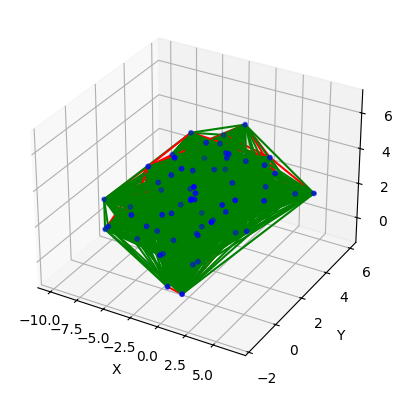

In [44]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, and z coordinates
x,y,z = [], [], []
for i in range(N_ATOMS):
    x.append(final_sub.X[i][0])
    y.append(final_sub.X[i][1])
    z.append(final_sub.X[i][2])

# Plot the atoms
ax.scatter(x, y, z, c='b', marker='o', s=10)

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot the lines between connected atoms
good, bad = 0,0
for i,j in dico_interval:
    if i<j:
        continue
    x_link_1, y_link_1, z_link_1 = final_sub.X[final_sub.index_to_X[i]]
    x_link_2, y_link_2, z_link_2 = final_sub.X[final_sub.index_to_X[j]]

    mini, maxi = dico_interval[(i,j)]

    color = (mini < ((x_link_1 - x_link_2)**2 + (y_link_1 - y_link_2)**2 + (z_link_1 - z_link_2)**2)**.5 < maxi )

    if color:
        ax.plot((x_link_1, x_link_2), (y_link_1, y_link_2), (z_link_1, z_link_2), c='g')
        good +=1
    else:
        ax.plot((x_link_1, x_link_2), (y_link_1, y_link_2), (z_link_1, z_link_2), c='r')
        bad +=1

print(good, bad, good/(bad+good))

# Show the 3D plot
plt.show()

## Marco DSP

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
from newton_tr_bounds import minimize_bounds

In [46]:
#creation_of_the_problems_values
"""
    function that takes all our values and format it to make it usable for the algorithm
    We want P and X such that f(x,y,z) = h(P.T * X) = sum[i,j] {||p(i)-p(j)||**2 - C(i,j)} with C(i,j) contrainte de notre algo
"""
n_atomes = 63
list_pos_temp = []
for i in range(n_atomes):
    list_pos_temp.append(final_sub.X[i][0])
    list_pos_temp.append(final_sub.X[i][1])
    list_pos_temp.append(final_sub.X[i][2])
X = np.array(list_pos_temp)
print(X.shape)

def vector_creation(X, i):
    return np.array((X[i*3], X[i*3+1], X[i*3+2]))

def difference(X, i, j):
    x = vector_creation(X, i)
    y = vector_creation(X, j)
    return (x-y)

def norm(vector):
    return np.linalg.norm(vector)

def problem_function(X, relation, constraint):
    res = 0
    for i,j in relation:
        res += (norm(difference(X,i,j))**2 - constraint[i,j])**2
    return res
def define_problem_function(lambda_k):
    """
        We have thanks to the paper: 
            <f>(λ, X) = <h>(sqrt(2λ), x(i) - x(j)) cf Th 4.1
            cf Th 4.2 too
        
    """

    def h(x, constraint):
        return (norm(x)**2 - constraint**2)**2

    def h_gauss_lambda(x, constraint, lambdak, p=3):
        result = h(x, constraint) + (3 + (p-1))* lambdak **2 * norm(x)**2 + .25*p*(p+2)*lambdak**4 - p*constraint**2*lambdak**2
        return result

    def f_gauss_λ(X, relation, constraint, lambda_k, h_g_l):
        res = 0
        for (i,j) in relation:
            cons_temp = constraint[i,j]
            x = difference(X, i, j)
            res += h_g_l(x, cons_temp, lambda_k)
        return res        

    def update_array(heussian, i, j, ddx, ddy, ddz):
        dd_list = [ddx, ddy, ddz]
        for A in [3*i, 3*j]:
            for B in [3*i, 3*j]:
                for a in range(3):
                    for b in range(3):
                        if a==b:
                            continue
                        to_add = 2 * dd_list[a] * dd_list[b]
                        heussian[A+a, B+b] += to_add
        return heussian

    def compute_grad_x_k(X, relation, constraint,lambda_k, n_atomes = n_atomes, p=3):
        grad = np.zeros((n_atomes*3))
        heussian_matrix = np.zeros((n_atomes*3, n_atomes * 3))
        for (i,j) in relation:
            # Do it for i and then for j
            # And in the order x, y, z
            grad_relation = 2*(norm(difference(X, i, j))**2 -  constraint[i,j]**2) + 2*(3 + (p-1)) * lambda_k**2 #cf 4.3 theorem

            #d/dx(i)
            ddx = 2 * (X[3*i] - X[3*j])
            grad[3*i] += grad_relation * ddx
            grad[3*j] += grad_relation * (-ddx)
            
            #d/dy(i)
            ddy = 2 * (X[3*i+1] - X[3*j+1])
            grad[3*i] += grad_relation * ddy
            grad[3*j] += grad_relation * (-ddy)

            #d/dz(i)
            ddz = 2 * (X[3*i+2] - X[3*j+2])
            grad[3*i] += grad_relation * ddz
            grad[3*j] += grad_relation * (-ddz)

            #Compute the heussian matrix d/(da(k))**2 for a € {x,y,z} and k {i,j}
            heussian_matrix[3*i  ,3*i  ] += 2 * grad_relation + 2 * ddx**2
            heussian_matrix[3*i+1,3*i+1] += 2 * grad_relation + 2 * ddy**2
            heussian_matrix[3*i+2,3*i+2] += 2 * grad_relation + 2 * ddz**2
            heussian_matrix[3*j  ,3*j  ] += 2 * grad_relation + 2 * ddx**2
            heussian_matrix[3*j+1,3*j+1] += 2 * grad_relation + 2 * ddy**2
            heussian_matrix[3*j+2,3*j+2] += 2 * grad_relation + 2 * ddz**2

            #Compute the heussian matrix on d/da(i)da(j)  for a € {x,y,z}
            heussian_matrix[3*i  ,3*j  ] -= 2 * grad_relation + 2 * ddx**2
            heussian_matrix[3*j  ,3*i  ] -= 2 * grad_relation + 2 * ddx**2

            heussian_matrix[3*i+1,3*j+1] -= 2 * grad_relation + 2 * ddy**2
            heussian_matrix[3*j+1,3*i+1] -= 2 * grad_relation + 2 * ddy**2

            heussian_matrix[3*i+2,3*j+2] -= 2 * grad_relation + 2 * ddz**2
            heussian_matrix[3*j+2,3*i+2] -= 2 * grad_relation + 2 * ddz**2            

            #Compute  the heussian matrix d/da(m)db(n) for a,b € {x,y,z} and n,m€ {i,j} tq a!=b
            heussian_matrix = update_array(heussian_matrix, i, j, ddx, ddy, ddz)
  
        return grad, heussian_matrix   

    return f_gauss_λ, h_gauss_lambda, compute_grad_x_k, update_array


def compute_quadratic_model_qk(grad_X_k, Heussian_matrix_X_k):
    """Cf section 4"""

    def function_quadratic(w):
        return (grad_X_k.T @ w + 0.5 * w.T @ Heussian_matrix_X_k @ w)
    
    def grad_quadratic_function(w):
        return grad_X_k + (Heussian_matrix_X_k + Heussian_matrix_X_k.T) @ w
    
    def heussian_f(w):
        return (Heussian_matrix_X_k + Heussian_matrix_X_k.T)
    
    return function_quadratic, grad_quadratic_function, heussian_f
def compute_scaling_matrix_Dk():
    """TODO but don't know"""
    return None
def compute_approximate_solution_sk(q_k, D_k, Delta_k, grad_q_k, Heussian_q_k):
    """find a min of qk(w) such that D_k * w <= Delta_k (Moré and Sorensen [18])"""

    return minimize(q_k, grad_q_k, Heussian_q_k, np.zeros((n_atomes * 3)), np.zeros((n_atomes * 3)), Delta_k)
    
def compute_ratio_rok(relation, constraint, X_k, sk, q_k):
    top = (problem_function(X_k + sk, relation, constraint) - problem_function(X_k, relation, constraint))
    bottom = q_k(sk)
    return top/bottom

def update_Delta_k():
    """TODO but don't know"""
    return np.ones((n_atomes * 3))

def find_minimizer_x(relation, constraint):

    X_k = X.copy()

    lambda_0 = 100 #TODO
    maxiter = 20000 #TODO
    Delta_k = update_Delta_k()
    nu0 = 0.1 #TODO

    for k in range(maxiter):
        lambda_k = (1-k/maxiter) * lambda_0
        f_gauss_λ, h_gauss_lambda, compute_grad_x_k, update_array = define_problem_function(lambda_k) #DONE
        gradient_X_k, Heussian_matrix_X_k = compute_grad_x_k(X_k, relation, constraint,lambda_k) #OK
        q_k, grad_q_k, Heussian_q_k = compute_quadratic_model_qk(gradient_X_k, Heussian_matrix_X_k) #DONE
        D_k = compute_scaling_matrix_Dk() #OK
        sk, _ = compute_approximate_solution_sk(q_k, D_k, Delta_k, grad_q_k, Heussian_q_k) #DONE
        rok = compute_ratio_rok(relation, constraint, X_k, sk, q_k)
        if rok >= nu0:
            X_k = X_k + sk
        else:
            Delta_k = update_Delta_k()
    return X_k

X_s = find_minimizer_x(list_relation, dico_constrains)
result = []
for i in range(n_atomes):
    result.append(np.array((X_s[3*i], X_s[3*i+1], X_s[3*i+2])))
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, and z coordinates
x,y,z = [], [], []
for i in range(n_atomes):
    x.append(X_s[3*i])
    y.append(X_s[3*i+1])
    z.append(X_s[3*i+2])

# Plot the atoms
ax.scatter(x, y, z, c='b', marker='o', s=100)

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot the lines between connected atoms
for link in dico_constrains:

    x_link_1, y_link_1, z_link_1 = result[link[0]].T
    x_link_2, y_link_2, z_link_2 = result[link[1]].T
    mini, maxi = dico_interval[link]

    color = (mini < ((x_link_1 - x_link_2)**2 + (y_link_1 - y_link_2)**2 + (z_link_1 - z_link_2)**2)**.5 < maxi )

    if color:
        ax.plot((x_link_1, x_link_2), (y_link_1, y_link_2), (z_link_1, z_link_2), c='g')
    else:
        ax.plot((x_link_1, x_link_2), (y_link_1, y_link_2), (z_link_1, z_link_2), c='r')



# Show the 3D plot
plt.show()

(189,)


AttributeError: 'numpy.ndarray' object has no attribute 'lower'